# Lista 1 - Deep Learning

Humberto Navarro - 20190029131

Lara Pontes - 20190031550

Tales Nobre - 20200025983

## Questão 1

Vamos resolver a questão 1 sem o uso de funções prontas. Para isso, definiremos as classes Perceptron e RosenblattPerceptron. A primeira define um único perceptron, com a inicialização aleatória dos pesos em valores próximos a zero e a sua atualização, seguindo a regra delta. A segunda, por sua vez, define uma única camada de perceptrons, com a função sinal (retornando 1 se a entrada for 0) como função de ativação, devido à natureza da base de dados proposta pela questão.

In [40]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from random import seed, random
from math import tanh, inf

As constantes a seguir foram calibradas para garantir uma rápida e eficaz convergência do modelo.

In [41]:
# Define constants
RAND_RATE = 1e-01
LEARNING_RATE = 1e-03
SAMPLES = 1000
MAX_ITER = 50

### Implementando o Perceptron e o RosenblattPerceptron

Na classe Perceptron, o parâmetro length define o tamanho do vetor de pesos, e o parâmetro rand_rate define o intervalo de inicialização dos pesos.

In [42]:
class Perceptron:
  def __init__(self, length, rand_rate = RAND_RATE):
    self.weights = [random()*rand_rate for _ in range(length)] # initialize weights with small random numbers within [0, rand_rate)

  def update_weights(self, x, err, learning_rate = LEARNING_RATE):
    for i in range(len(x)):
      self.weights[i] += learning_rate*err*x[i]

Na classe RosenblattPerceptron, o parâmetro n define o número de perceptrons da camada.

In [43]:
class RosenblattPerceptron:
  def __init__(self, n, length, rand_rate = RAND_RATE):
    self.network = [Perceptron(length, rand_rate) for _ in range(n)]

  def output(self, x):
    output = []
    for v in self.network:
      if np.dot(x, v.weights) >= 0:
        output.append(1)
      else:
        output.append(-1)
    return output

  def update_weights(self, x, err, learning_rate = LEARNING_RATE):
    for i, v in enumerate(self.network):
      v.update_weights(x, err[i], learning_rate)

### Implementando a função de treinamento

Um detalhe importante da função de treinamento é o acréscimo de 1 no parâmetro length passado para o RosenblattPerceptron. Isso se deve à definição do bias como um elemento a mais na entrada, que será discutido posteriormente no pré-processamento do banco de dados.

In [44]:
def rna_learning(n, length, training_set, rand_rate = RAND_RATE, learning_rate = LEARNING_RATE, verbose = True):
  # Instantiate single-layer perceptron
  network = RosenblattPerceptron(n, length + 1, rand_rate) # length + 1 because of bias
  while True:
    sum_err = 0
    err_count = 0
    for example, expected_out in training_set:
      network_out = network.output(example)
      # Calculate error
      example_err = [(expected_out[i] - network_out[i]) for i in range(len(expected_out))]
      sum_err += 1/2*sum((expected_out[i] - network_out[i])**2 for i in range(len(expected_out)))
      # Update weights
      network.update_weights(example, example_err, learning_rate)
      # Count errors for accuracy
      if network_out != expected_out:
        err_count += 1
    if verbose:
      print("Accuracy:", (len(training_set) - err_count)/len(training_set))
      print("Mean error:", sum_err/len(training_set))
    # Stopping criterion
    if (len(training_set) - err_count)/len(training_set) == 1:
      break
  return network

### Gerando o dataset

A função perturb_input adiciona ruído dentro do raio definido para as entradas padrão, seguindo uma distribuição uniforme.

In [45]:
# Perturb input values inside the noise ratio
def perturb_input(x, ratio = 1e-01):
  perturbed_x = x.copy()
  for i in range(len(perturbed_x)):
    perturbed_x[i] += np.random.uniform(-ratio, ratio)
  return perturbed_x

In [46]:
pure_x = [
  [0, 0, 0],
  [0, 0, 1],
  [0, 1, 0],
  [0, 1, 1],
  [1, 0, 0],
  [1, 0, 1],
  [1, 1, 0],
  [1, 1, 1]
]

expected_output = [
  [1, -1, -1, -1, -1, -1, -1, -1],
  [-1, 1, -1, -1, -1, -1, -1, -1],
  [-1, -1, 1, -1, -1, -1, -1, -1],
  [-1, -1, -1, 1, -1, -1, -1, -1],
  [-1, -1, -1, -1, 1, -1, -1, -1],
  [-1, -1, -1, -1, -1, 1, -1, -1],
  [-1, -1, -1, -1, -1, -1, 1, -1],
  [-1, -1, -1, -1, -1, -1, -1, 1]
]

In [47]:
# Create dataset
dataset = [(pure_x[i], expected_output[i]) for i in range(len(pure_x))]
input_class = [pure_x[i] + [i%8] for i in range(len(pure_x))] # for plotting
for _ in range(SAMPLES):
  perturbed_x = [perturb_input(x) for x in pure_x]
  dataset += [(perturbed_x[i], expected_output[i]) for i in range(len(pure_x))]
  input_class += [perturbed_x[i] + [i%8] for i in range(len(pure_x))]

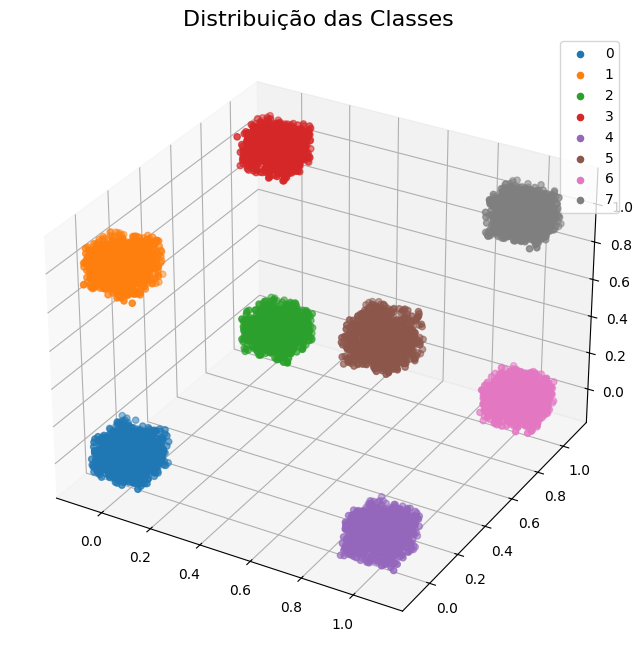

In [48]:
# Print data
data = pd.DataFrame(input_class, columns=['x', 'y', 'z', 'class'])
data.head()

classes = data['class'].unique()

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')

for c in classes:
    values = data[data['class'] == c].values
    x, y, z = values[:,0] , values[:,1], values[:,2]
    ax.scatter(x, y, z, label=c)

ax.set_title("Distribuição das Classes", fontsize=16)
ax.legend(loc="best");

Com o banco de dados criado, faremos um pré-processamento para possibilitar a utilização do bias. O bias é responsável por adicionar uma constante ao produto interno entre a entrada e o vetor de pesos. Uma forma de implementar isso é acrescentar um elemento na entrada com valor 1, pois seu produto com o peso correspondente (bias) adicionará uma constante ao resultado final.

In [49]:
# Preprocess data to add bias
def preprocess_data(training_set):
  preprocessed_training_set = []
  for example, expected_out in training_set:
    preprocessed_training_set.append(([1] + example, expected_out))
  return preprocessed_training_set

A seguir, utilizaremos a biblioteca sklearn apenas para particionar o conjunto de dados gerados em conjuntos de treinamento e de validação.

In [50]:
from sklearn.model_selection import train_test_split

# Preprocess data
dataset = preprocess_data(dataset)

# Separate dataset into training and validation sets
training_set, validation_set = train_test_split(dataset, test_size=0.2)

### Treinando a rede

Para treinar a rede, basta chamar a função rna_learning com os argumentos indicando as 8 classes, o tamanho 3 dos vetores de entrada e o conjunto de treinamento.

In [51]:
# Train network
network = rna_learning(8, 3, training_set)

Accuracy: 0.9525444895410553
Mean error: 0.202622541367468
Accuracy: 1.0
Mean error: 0.0


### Analisando os resultados

Por meio da execução do modelo no conjunto de validação, atestamos que a acurácia alcançada é de 100%.

In [52]:
err_count = 0
for example, expected_out in validation_set:
  converted_out = network.output(example)
  if converted_out != expected_out:
    print('Model output:\t\t', converted_out)
    print('Expected output:\t', expected_out)
    err_count += 1
print('Accuracy:', (len(validation_set) - err_count)/len(validation_set))

Accuracy: 1.0
